# **LOF, IF, PCA Washing Machine (Tumbling Shoes Anomaly)**

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
import pandas as pd
import itertools

## Dataset

In [2]:
# Paths to audio files
anomalous_audio_path = "../../Data/raw/12_wm/A_12_wm.wav"
normal_audio_path = "../../Data/raw/12_wm/N_12_wm.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/anomalous_frames_LOF_wm.npy"
output_normal_frames_path = "../../Data/frames/normal_frames_LOF_wm.npy"
train_frames_path = "../../Data/datasets/train_frames_LOF_wm.npy"
val_frames_path = "../../Data/datasets/val_frames_LOF_wm.npy"
test_frames_path = "../../Data/datasets/test_frames_LOF_wm.npy"
test_labels_path = "../../Data/datasets/test_labels_LOF_wm.npy"

# Ensure directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)

## Spectrogram and Frames Generation

In [3]:
# Adjustable parameters for audio -> spectrogram frames
time_per_frame = 0.6   # seconds per frame
hop_ratio      = 0.2   # overlap ratio between consecutive frames
hop_length     = 512   # STFT hop (used in librosa.stft)

# Function to generate a normalized Mel-spectrogram
def generate_mel_spectrogram(audio_path):
    """
    Load an audio file, compute Mel-spectrogram, and normalize to [0, 1].
    Returns:
      mel_db_norm: (n_mels, time_frames)
      sr         : sampling rate
    """
    audio, sr = librosa.load(audio_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=hop_length)
    mel  = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to [0, 1]
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr

# Function to generate overlapping frames from a Mel-spectrogram
def generate_frames(mel_spectrogram, frame_size, hop_size):
    """
    From a 2D mel_spectrogram (n_mels x time_frames),
    generate overlapping frames: shape (num_frames, n_mels, frame_size).
    """
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames

print("Loading anomalous audio and generating spectrogram...")
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path)
print("Loading normal audio and generating spectrogram...")
mel_db_normal, sr_normal       = generate_mel_spectrogram(normal_audio_path)

assert sr_anomalous == sr_normal, "Sampling rates do not match!"

# Calculate frame and hop sizes in terms of STFT frames
frame_size = int((time_per_frame * sr_anomalous) / hop_length)
hop_size   = int(frame_size * hop_ratio)

print("Generating frames for anomalous audio...")
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
print("Generating frames for normal audio...")
normal_frames    = generate_frames(mel_db_normal, frame_size, hop_size)

# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)
print(f"Saved anomalous frames to {output_anomalous_frames_path}")
print(f"Saved normal frames    to {output_normal_frames_path}")

Loading anomalous audio and generating spectrogram...
Loading normal audio and generating spectrogram...
Generating frames for anomalous audio...
Generating frames for normal audio...
Saved anomalous frames to ../../Data/frames/anomalous_frames_LOF_wm.npy
Saved normal frames    to ../../Data/frames/normal_frames_LOF_wm.npy


## Train and Test Splits

In [4]:
print("\nSplitting into train/val/test sets...")
# Load frames
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames    = np.load(output_normal_frames_path)

# Split normal frames into training, validation, and test sets
normal_train_val, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)
normal_train, normal_val = train_test_split(normal_train_val, test_size=0.1765, random_state=42)  # Approximately 15% of total normal data

print(f"normal_train shape: {normal_train.shape}")
print(f"normal_val   shape: {normal_val.shape}")
print(f"normal_test  shape: {normal_test.shape}")

# Combine normal_test and anomalous_frames for testing
test_frames = np.concatenate([normal_test, anomalous_frames], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_frames))])

# Shuffle the test set
indices = np.arange(len(test_frames))
np.random.shuffle(indices)
test_frames = test_frames[indices]
test_labels = test_labels[indices]

# Save datasets
np.save(train_frames_path, normal_train)
np.save(val_frames_path,   normal_val)
np.save(test_frames_path,  test_frames)
np.save(test_labels_path,  test_labels)

print("Data splits saved.\n")
print(f"Test set final shape = {test_frames.shape}")


Splitting into train/val/test sets...
normal_train shape: (7169, 128, 51)
normal_val   shape: (1537, 128, 51)
normal_test  shape: (1537, 128, 51)
Data splits saved.

Test set final shape = (2278, 128, 51)


## Flatten Data (2D => 1D) and Convert Labels for ML

In [5]:
loaded_train = np.load(train_frames_path)  # shape: (num_train, freq_bins, frame_size)
freq_bins    = loaded_train.shape[1]       # e.g., 128
frame_size   = loaded_train.shape[2]       # e.g., 20, 25, etc.

# Reload so we have consistent variables
X_train_3d = np.load(train_frames_path)  # normal-only
X_val_3d   = np.load(val_frames_path)    # also normal-only
X_test_3d  = np.load(test_frames_path)
y_test_raw = np.load(test_labels_path)   # 0=normal, 1=anomaly

# Flatten
#  => shape: (num_samples, freq_bins * frame_size)
X_train = X_train_3d.reshape(len(X_train_3d), -1)
X_val   = X_val_3d.reshape(len(X_val_3d), -1)
X_test  = X_test_3d.reshape(len(X_test_3d), -1)

# Because the validation set here is normal only, we can (optionally) create
# a label vector y_val with all 0 (normal) => which becomes 1 for LOF.
y_val_raw = np.zeros(len(X_val_3d))  # all normal
# Convert to {1=normal, -1=anomaly}
y_val  = np.where(y_val_raw == 0, 1, -1)
y_test = np.where(y_test_raw == 0, 1, -1)

print(f"Training set shape: {X_train.shape} (normal only)")
print(f"Validation set shape: {X_val.shape}, normal only => y_val in {{1}}")
print(f"Test set shape: {X_test.shape}, labels in {{1 (normal), -1 (anomaly)}}")

Training set shape: (7169, 6528) (normal only)
Validation set shape: (1537, 6528), normal only => y_val in {1}
Test set shape: (2278, 6528), labels in {1 (normal), -1 (anomaly)}


## Utility Functions for Thresholding & Metrics

In [6]:
def evaluate_at_threshold(scores, y_true, threshold):
    preds = np.where(scores >= threshold, 1, -1)
    rec   = recall_score(y_true, preds, pos_label=-1)
    prec  = precision_score(y_true, preds, pos_label=-1)
    f1    = f1_score(y_true, preds, pos_label=-1)
    return rec, prec, f1, preds

def find_best_threshold(scores, y_true, metric="f1", 
                        step_percentiles=(5, 95), num_steps=30):
    # Because the validation set is normal-only, y_true==1 for all samples.
    # We thus pick thresholds based on normal distribution of scores.
    normal_scores = scores[y_true == 1]
    if len(normal_scores) == 0:
        normal_scores = scores

    low_val  = np.percentile(normal_scores, step_percentiles[0])
    high_val = np.percentile(normal_scores, step_percentiles[1])
    thresholds = np.linspace(low_val, high_val, num_steps)

    best_thr        = thresholds[0]
    best_metric_val = -np.inf
    best_preds      = None

    for thr in thresholds:
        rec, prec, f1, preds = evaluate_at_threshold(scores, y_true, thr)
        if metric == "f1":
            this_val = f1
        elif metric == "precision":
            this_val = prec
        elif metric == "recall":
            this_val = rec
        else:
            this_val = f1

        if this_val > best_metric_val:
            best_metric_val = this_val
            best_thr        = thr
            best_preds      = preds

    return best_thr, best_metric_val, best_preds

## Manual "Grid Search" for LOF & IF + optional PCA

In [7]:
def _iterate_params(param_grid):
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    for combo in itertools.product(*values):
        yield dict(zip(keys, combo))

def manual_grid_search(X_train, X_val, y_val, possible_pca, model_type="LOF"):
    results = []
    scaler  = MinMaxScaler(feature_range=(-5, 5))

    if model_type == "LOF":
        param_grid = {
            "n_neighbors":   [5, 10, 20],
            "contamination": [0.05, 0.1],
        }
    else:  # Isolation Forest
        param_grid = {
            "n_estimators":  [50, 100],
            "max_samples":   ["auto", 0.5],
            "contamination": [0.05, 0.1],
        }

    for pca_ratio in possible_pca:
        for params in _iterate_params(param_grid):
            steps = [("scaler", scaler)]
            if pca_ratio is not None:
                pca = PCA(pca_ratio)
                steps.append(("pca", pca))

            # model
            if model_type == "LOF":
                model = LocalOutlierFactor(
                    novelty=True,
                    n_neighbors=params["n_neighbors"],
                    contamination=params["contamination"]
                )
            else:
                model = IsolationForest(
                    n_estimators=params["n_estimators"],
                    max_samples=params["max_samples"],
                    contamination=params["contamination"],
                    random_state=42
                )

            steps.append(("classifier", model))
            pipeline = Pipeline(steps)

            # Fit on normal-only training data
            pipeline.fit(X_train)

            # Transform X_val
            X_val_transformed = pipeline[:-1].transform(X_val)
            val_scores        = pipeline[-1].decision_function(X_val_transformed)

            best_thr, best_f1, best_preds = find_best_threshold(
                val_scores, y_val, metric="f1", step_percentiles=(5,95), num_steps=30
            )

            # Because y_val is all normal => recall or precision for anomalies
            # on the val set won't be meaningful. We can track F1=0 if we had anomalies.
            rec, prec, final_f1, _ = evaluate_at_threshold(val_scores, y_val, best_thr)

            # Just for logging
            auc_val = 0.0  

            results.append((pca_ratio, params, best_thr, auc_val, rec, prec, final_f1, pipeline))

    return results

## Run the "Manual Grid Search" and Evaluate on Test

In [8]:
def run_search_and_evaluate(X_train, X_val, y_val, X_test, y_test):
    possible_pca_ratios = [None, 0.8, 0.9, 0.95]

    # LOF
    lof_results = manual_grid_search(X_train, X_val, y_val, possible_pca_ratios, model_type="LOF")
    # best by final_f1 => index 6
    lof_best = max(lof_results, key=lambda x: x[6])
    (lof_pca, lof_params, lof_thr, lof_auc, lof_rec, lof_prec, lof_f1, lof_pipe) = lof_best

    # IF
    if_results = manual_grid_search(X_train, X_val, y_val, possible_pca_ratios, model_type="IF")
    if_best = max(if_results, key=lambda x: x[6])
    (if_pca, if_params, if_thr, if_auc, if_rec, if_prec, if_f1, if_pipe) = if_best

    best_method   = "LOF"
    best_val_f1   = lof_f1
    best_thr      = lof_thr
    best_pipeline = lof_pipe

    if if_f1 > best_val_f1:
        best_method   = "IF"
        best_val_f1   = if_f1
        best_thr      = if_thr
        best_pipeline = if_pipe

    print("\n========================================")
    print(f"Best method on (normal-only) validation set: {best_method} (F1={best_val_f1:.3f})")
    print(f"Threshold chosen: {best_thr:.4f}")

    # Evaluate on test
    X_test_trans = best_pipeline[:-1].transform(X_test)
    test_scores  = best_pipeline[-1].decision_function(X_test_trans)
    test_preds   = np.where(test_scores >= best_thr, 1, -1)

    # Compute real metrics
    test_auc     = roc_auc_score(y_test, test_scores)
    test_recall  = recall_score(y_test, test_preds, pos_label=-1)
    test_prec    = precision_score(y_test, test_preds, pos_label=-1)
    test_f1      = f1_score(y_test, test_preds, pos_label=-1)

    print("----- TEST RESULTS -----")
    print(f"Method        : {best_method}")
    print(f"Test AUC      : {test_auc:.3f}")
    print(f"Test Recall   : {test_recall:.3f}")
    print(f"Test Prec     : {test_prec:.3f}")
    print(f"Test F1       : {test_f1:.3f}")
    print("========================================\n")

    conf_mat = confusion_matrix(y_test, test_preds, labels=[1, -1])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                  display_labels=['Normal (1)', 'Anomalous (-1)'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({best_method} on Test Set)')
    plt.show()

    return best_method, best_pipeline, best_thr

## Final Execution

In [9]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress only UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


Best method on (normal-only) validation set: LOF (F1=0.000)
Threshold chosen: 0.0085
----- TEST RESULTS -----
Method        : LOF
Test AUC      : 0.988
Test Recall   : 0.980
Test Prec     : 0.912
Test F1       : 0.945



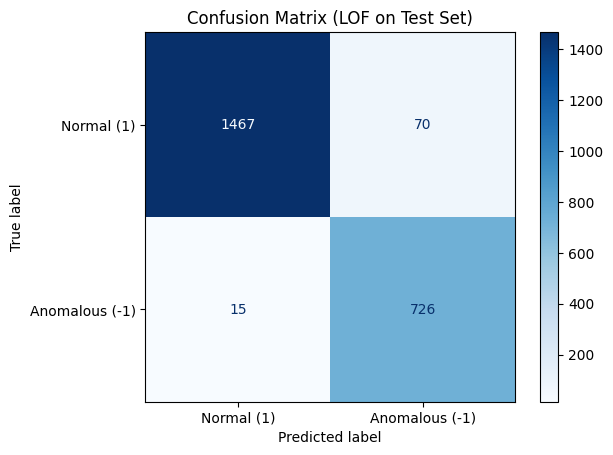

Correctly classified anomalies: [   1    2    5   10   16   17   22   24   29   32   34   36   38   41
   45   46   52   53   58   61   63   73   76   77   81   83   85   88
   90   91   97   98  102  105  107  116  117  118  120  125  130  131
  134  137  138  143  145  150  155  158  160  165  169  170  173  175
  183  186  190  194  196  197  198  200  204  207  210  213  216  219
  225  226  230  231  236  247  252  258  261  265  271  275  279  281
  284  285  291  293  295  298  301  302  306  311  314  316  317  320
  322  325  327  332  335  336  337  340  341  345  346  352  353  363
  366  375  376  378  379  382  385  386  388  390  391  396  399  400
  401  402  409  411  412  418  419  420  428  432  434  439  443  448
  453  454  457  460  462  466  470  477  484  486  488  491  492  494
  496  498  500  502  511  518  528  532  534  538  539  541  545  548
  555  557  558  559  576  581  584  592  596  605  606  610  611  616
  619  620  622  630  634  638  642  645  646

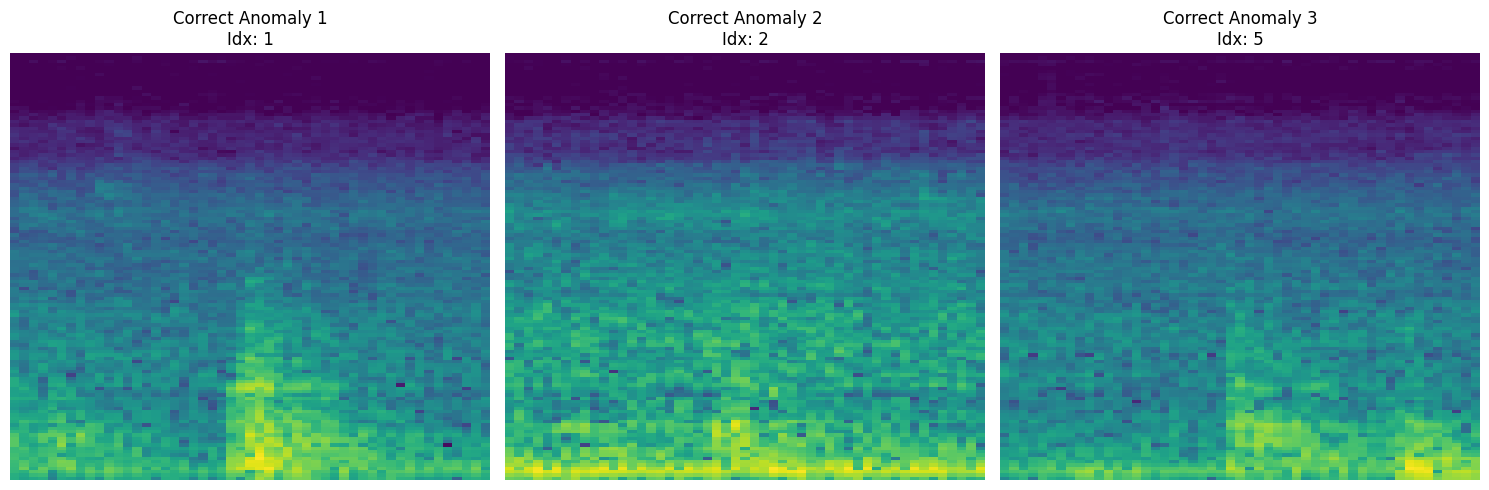

In [10]:
if __name__ == "__main__":
    best_method, best_pipeline, best_thr = run_search_and_evaluate(
        X_train, X_val, y_val, X_test, y_test
    )

    # Example: Identify misclassifications
    X_test_trans = best_pipeline[:-1].transform(X_test)
    test_scores  = best_pipeline[-1].decision_function(X_test_trans)
    test_preds   = np.where(test_scores >= best_thr, 1, -1)

    correctly_classified_anomalies = np.where((y_test == -1) & (test_preds == -1))[0]
    wrongly_classified_anomalies   = np.where((y_test == -1) & (test_preds == 1))[0]
    wrongly_classified_normals     = np.where((y_test == 1) & (test_preds == -1))[0]

    print("Correctly classified anomalies:", correctly_classified_anomalies)
    print("Wrongly classified anomalies  :", wrongly_classified_anomalies)
    print("Wrongly classified normals    :", wrongly_classified_normals)

    # Optionally, plot a few frames
    def plot_specified_frames(frames_flat, indices, freq_bins, frame_sz, title_prefix="Frame"):
        if len(indices) == 0:
            print(f"No frames to plot for {title_prefix}.")
            return
        frames_3d = frames_flat.reshape(frames_flat.shape[0], freq_bins, frame_sz)
        num_frames = len(indices)
        fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
        if num_frames == 1:
            axes = [axes]

        for i, idx in enumerate(indices):
            ax = axes[i]
            librosa.display.specshow(frames_3d[idx], cmap="viridis", ax=ax)
            ax.set_title(f"{title_prefix} {i+1}\nIdx: {idx}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    plot_specified_frames(X_test, correctly_classified_anomalies[:3],
                          freq_bins, frame_size, title_prefix="Correct Anomaly")